In [1]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import Counter 
%matplotlib inline
pth = "C:\EPFL\2018-2019\nltk_data"
nltk.data.path.append(pth)


# Data Exploration

## A : Data Format

In [2]:
liar_df = pd.read_csv('LIAR/train.tsv', sep='\t', header=None)

In [3]:
liar_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


labels : pants-fire, false, barelytrue, half-true, mostly-true, and true (distribution pretty-well balanced) ** other attributes : subject, author of the statement, what the author represent (media, government..), geographic origin (Us state), political party of the author, the credit history vector of the author (counts of pants fire, false, barelytrue...) and the where the statement was emitted. (campaign debate, press release, website...)

In [4]:
liar_df.columns = ['trash', 'label', 'text', 'subject', 'author', 'function', 'state', 'political_party', 'pants_on_fire'\
                  , 'false', 'barely true', 'half true', 'mostly true', 'source']
liar_df = liar_df.drop(columns='trash')
n_rows = liar_df.shape[0]

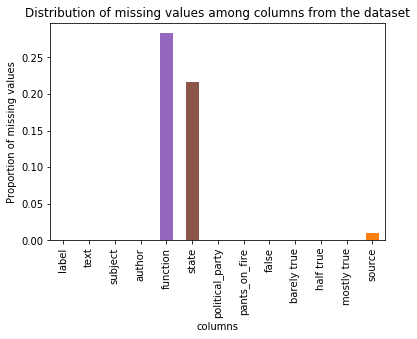

In [5]:
na_values = (liar_df.isnull().sum(axis = 0)/n_rows).plot(kind='bar') #proportion of na values in each column
plt.xlabel('columns')
plt.ylabel('Proportion of missing values')
plt.title('Distribution of missing values among columns from the dataset')
plt.show()

**We can see that except for the function of the author of the news and the state where the news were emitted, most of the data is not missing. However, for these two informations, they may be rather relevant for our classifier for example in terms of credibility (is it a government official saying this fact ?) and also if we want to classify where the fake news are the most spread and if there is some connection between the dominant political party in this state or not. The missing values represent more than 25% of the data for the function of the author and 20% for the state where the news is coming from. Hence we will need to decide after some investigation how to deal with them.**

## News Descriptive Analysis

**In order to have further insigh on what is inside the data. In the next subtask we will at first focus on the text news and their label only.**

In [6]:
news = liar_df[['label', 'text']]

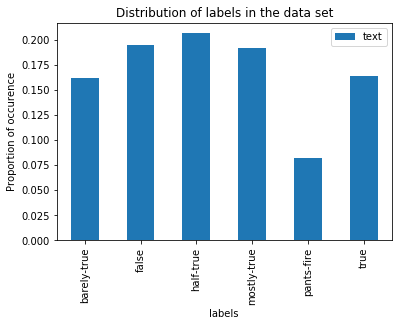

In [7]:
(news.groupby('label').count()/n_rows).plot(kind='bar')
plt.xlabel('labels')
plt.ylabel('Proportion of occurence')
plt.title('Distribution of labels in the data set')
plt.show()

**We can see that the distribution of the 6 labels is quite balanced except for the pants-fire label which is less present than the other labels present roughly a little bit less than 20% of the time.**

In [8]:
text = news[['label', 'text']]

In [9]:
def tokenization(t) : 
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    return tokenizer.tokenize(t)

In [10]:
for i in range(n_rows) : 
    t = text.iloc[i][1]
    text.iloc[i][1] = tokenization(t)

Separate the text according to their labels

In [43]:
false_news = text[text['label'] == 'false']
half_true_news =  text[text['label'] == 'half-true']
mostly_true_news =  text[text['label'] == 'mostly-true']
barely_true_news =  text[text['label'] == 'barely-true']
pants_fire_news =  text[text['label'] == 'pants-fire']
true_news =  text[text['label'] == 'true']

**Get most common words in text**

In [49]:
stopwords = ''
with open('stopw.txt') as f:
        # return the split results, which is all the words in the file.
        stopwords = f.read().split()

In [50]:
#helper function use to concatenate all sentences in big paragraph of words.
def create_dataset(array) :
    dataset = ''
    for i in range(len(array)) :
        dataset += ' '.join(array[i])
        dataset += ' '
    split_it = dataset.split()
    counter = Counter(split_it)
    return counter


def text_to_topics(df, sw) :
    #Get the sentences from the dataset
    sentences = df['text'].values
    
    #transform sentences to word tokens
    stemmer = nltk.stem.PorterStemmer()
    wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
    s = [[wordnet_lemmatizer.lemmatize(token) for token in li] for li in sentences]
    
    #transform word to lowercase and filter out stopwords
    for i in range(len(s)) :
        temp = []
        sent = s[i]
        for j in range(len(sent)) :#
            w = sent[j].lower()
            if(not w in sw) :
                #print('words : {}'.format(w))
                temp.append(w)
        s[i] = temp
    
    #return the topics
    dataset = create_dataset(s)
    dataset = pd.DataFrame(list(dataset.items()), columns=['word', 'occurences'])
    dataset = dataset.sort_values(by='occurences', ascending=False)
    return dataset

In [53]:
n =10

In [54]:
false_news_topics = text_to_topics(false_news, stopwords).head(n)
half_true_topics = text_to_topics(half_true_news, stopwords).head(n)
mostly_true_topics = text_to_topics(mostly_true_news, stopwords).head(n)
barely_true_topics = text_to_topics(barely_true_news, stopwords).head(n)
pants_fire_topics = text_to_topics(pants_fire_news, stopwords).head(n)
true_topics = text_to_topics(true_news, stopwords).head(n)

In [89]:
def show_topics(df, title, n) :
    df.plot(kind='bar', x='word', y='occurences')
    plt.title('{} most popular topics in {} news'.format(n, title))
    plt.xlabel('topics')
    plt.ylabel('occurences')
    plt.show()

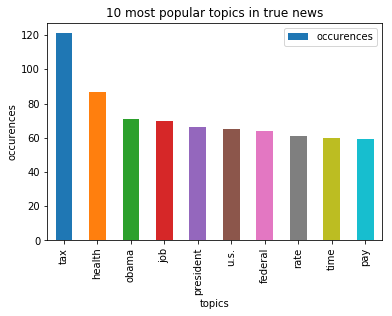

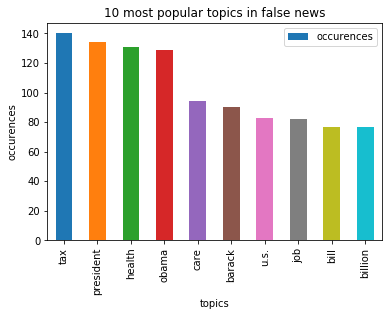

In [96]:
show_topics(true_topics, 'true', n)
show_topics(false_news_topics, 'false', n)

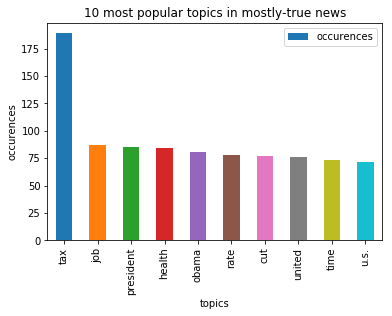

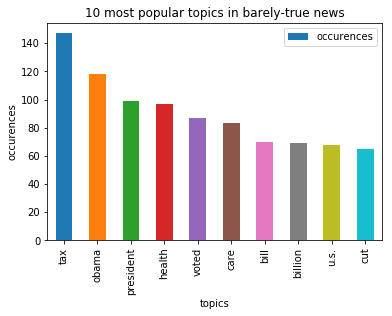

In [97]:
show_topics(mostly_true_topics, 'mostly-true', n)
show_topics(barely_true_topics, 'barely-true', n)

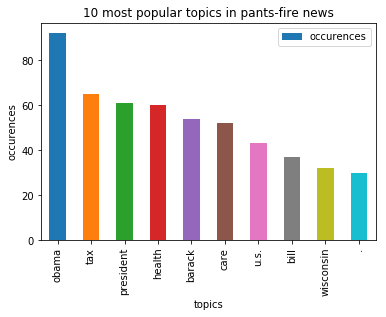

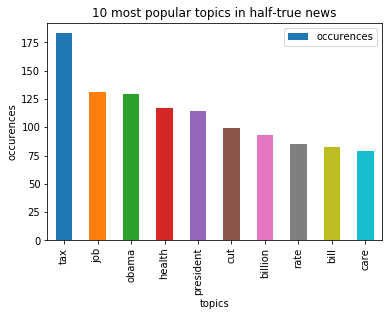

In [98]:
show_topics(pants_fire_topics, 'pants-fire', n)
show_topics(half_true_topics, 'half-true', n)

**and in the whole corpus**

In [99]:
whole_topics = text_to_topics(text, stopwords).head(n)

In [100]:
whole_topics.head()

,word,occurences
196,tax,845
265,obama,620
28,health,576
318,president,559
430,job,447


In [ ]:
show_topics(half_true_topics, 'half-true', n)